# WTI and DXY correlation 
- verify the assumption that since WTI - like Brent - are denominated in US dollars globally, 
a stronger dollar pressures crude prices.

Roadmap :
- Get WTI data
- Get DX-Y data -> USDX instead
- Join on date with maximum history
- Compute Pearson correlation
- Assess weather the correlation coefficient is relevant 
- Project out USDX onto WTI to get a first model of the crude idiosyncratic price

In [ ]:
import json
import requests
from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl
import pandas_datareader as pdr
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, probplot
from statsmodels.tsa.api import adfuller, kpss, VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

raw_data_folder = Path("../raw_data")
commo_folder = raw_data_folder / "commo"
commo_folder = commo_folder.resolve()
print(f"Raw data location : {commo_folder}\n")
print("Current data files :")
for p in list(commo_folder.glob("*")):
    print(f"\t- {p}")

Raw data location : /home/leonc/code/fixed-income-analytics/raw_data/commo

Current data files :
	- /home/leonc/code/fixed-income-analytics/raw_data/commo/Cushing_OK_WTI_Spot_Price_FOB.csv


## Load data

### WTI

In [2]:
# contains header

with open(commo_folder / "Cushing_OK_WTI_Spot_Price_FOB.csv") as f:
    for i in range(10):
        print(f.readline())

Cushing OK WTI Spot Price FOB

https://www.eia.gov/dnav/pet/hist/RWTCD.htm

09:19:15 GMT+0100 (British Summer Time)

Data Source: Thomson Reuters

Day,Cushing OK WTI Spot Price FOB  Dollars per Barrel

07/14/2025,68.19

07/11/2025,69.63

07/10/2025,67.78

07/9/2025,69.61

07/8/2025,69.55



In [3]:
wti = (
    pl.scan_csv(commo_folder / "Cushing_OK_WTI_Spot_Price_FOB.csv", skip_rows=4)
    .with_columns(pl.col("Day").str.to_date("%m/%d/%Y"))
    .rename(
        {"Cushing OK WTI Spot Price FOB  Dollars per Barrel": "WTI spot", "Day": "date"}
    )
)
wti.head().collect()

date,WTI spot
date,f64
2025-07-14,68.19
2025-07-11,69.63
2025-07-10,67.78
2025-07-09,69.61
2025-07-08,69.55


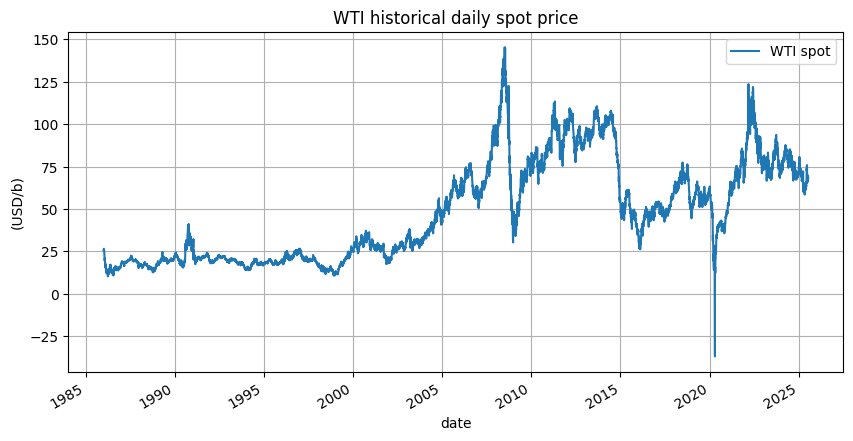

In [5]:
_ = (
    wti.collect()
    .to_pandas()
    .set_index("date")
    .plot(
        figsize=(10, 5),
        grid=True,
        ylabel="(USD/b)",
        title="WTI historical daily spot price",
    )
)

### DX-Y / USDX / Dixie

In [6]:
# Yahoo finance decomissioned
# history not available in alphavantage

dxy_ticker = "DX-Y.NYB"
alternative_ticker = "USDX"

ALPHAVANTAGE_API_KEY = "FTGVVCR5TZVEY9ZH"

In [7]:
for ticker in [dxy_ticker, alternative_ticker]:
    search_url = f"https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={ticker}&apikey={ALPHAVANTAGE_API_KEY}"
    search_result = requests.get(search_url).json()
    print(json.dumps(search_result, indent=2) + "\n")


quote_url = f"https://www.alphavantage.co/query?function=HISTORICAL_OPTIONS&symbol={alternative_ticker}&apikey={ALPHAVANTAGE_API_KEY}&date=2023-06-25"
r = requests.get(quote_url)
data = r.json()

print(json.dumps(data, indent=2))

{
  "bestMatches": []
}

{
  "bestMatches": [
    {
      "1. symbol": "USDX",
      "2. name": "SGI ENHANCED CORE ETF ",
      "3. type": "ETF",
      "4. region": "United States",
      "5. marketOpen": "09:30",
      "6. marketClose": "16:00",
      "7. timezone": "UTC-04",
      "8. currency": "USD",
      "9. matchScore": "1.0000"
    }
  ]
}

{
  "endpoint": "Historical Options",
  "message": "No data for symbol USDX on date 2023-06-25. Please specify a valid combination of symbol and trading day.",
  "data": []
}


### Fetching data from local proxy API service

In [13]:
!podman ps

CONTAINER ID  IMAGE                                                             COMMAND               CREATED        STATUS        PORTS                   NAMES
6bc63067b4a0  6199185dbc2a16d93e0271263a1ba657a0481e1ad159c872c3d58b5f24f6e061  uvicorn --host 0....  5 minutes ago  Up 5 minutes  0.0.0.0:8000->8000/tcp  jolly_bartik


In [16]:
!podman inspect 6bc63067b4a0 | grep Network
!podman inspect 6bc63067b4a0 | grep -i ip

print("\nIP is localhost since container is not WSL but running in main OS Ubuntu")

          "NetworkSettings": {
               "NetworkMode": "slirp4netns",
               "IPAddress": "",
               "IPPrefixLen": 0,
               "IPv6Gateway": "",
               "GlobalIPv6Address": "",
               "GlobalIPv6PrefixLen": 0,
               "LinkLocalIPv6Address": "",
               "LinkLocalIPv6PrefixLen": 0,
                              "HostIp": "",
                    "org.opencontainers.image.description": "An extremely fast Python package and project manager, written in Rust.",
                              "HostIp": "",
               "IpcMode": "shareable",

IP is localhost since container is not WSL but running in main OS Ubuntu


In [8]:
# check that the API service is available (running in podman localhost)
STATE = "dev"

ipx = {"API": {"dev": "http://127.0.0.1:8000/", "staging": "http://0.0.0.0:8000/"}}

# query max dollar index history with pandas_datareader API (from FRED)

usdx_url = ipx["API"][STATE] + "pdr/usdx"

res = requests.get(usdx_url)
if res.status_code == 404:
    print("Service not available")

else:
    usdx = pd.DataFrame(json.loads(res.json()))
    usdx["date"] = usdx["date"].apply(lambda d: pd.Timestamp(d, unit="ms")).dt.date
    usdx = usdx.set_index("date")


## Correlation

In [255]:
df = wti.join(
    pl.from_pandas(usdx.reset_index()).with_columns(pl.col("date").dt.date()).lazy(),
    on="date",
    how="inner",
)

print(f"Number of days joined : {df.select(pl.len()).collect().item()}")

Number of days joined : 4902


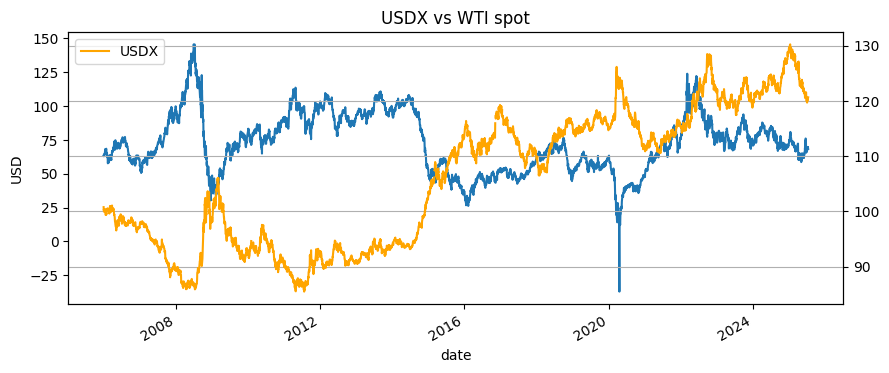

In [357]:
df_p = df.collect().to_pandas().set_index("date")

_, ax = plt.subplots(figsize=(10, 4))
ax_twin = ax.twinx()
df_p["WTI spot"].plot(ax=ax, ylabel="USD")
df_p["USDX"].plot(ax=ax_twin, c="orange", grid=True, legend=True)
_ = ax.set_title("USDX vs WTI spot")

In [259]:
print(
    f"Pearson correlation coefficient : {
df.select(
    pl.corr(
        pl.col("WTI spot"), 
        pl.col("USDX"),
        method="pearson"
    )
).collect().item()
}"
)

Pearson correlation coefficient : -0.48840042991376165


In [260]:
df_no_nans = df.drop_nulls()
pr = pearsonr(
    df_no_nans.select(pl.col("WTI spot")).collect().to_numpy().T[0],
    df_no_nans.select(pl.col("USDX")).collect().to_numpy().T[0],
)
print(f"Pearson coefficient : {np.round(pr.statistic, decimals=3)}")
print(f"p-value : {np.round(pr.pvalue, decimals=5)}")
rho = pr.statistic

Pearson coefficient : -0.488
p-value : 0.0


### Linear projection

In [261]:
wti_np = df_no_nans.select(pl.col("WTI spot")).collect().to_numpy().T[0]
usdx_np = df_no_nans.select(pl.col("USDX")).collect().to_numpy().T[0]

(osm_w, osr_w), (a_w, b_w, _) = probplot(wti_np, dist="norm", fit=True)
(osm_u, osr_u), (a_u, b_u, _) = probplot(usdx_np, dist="norm", fit=True)

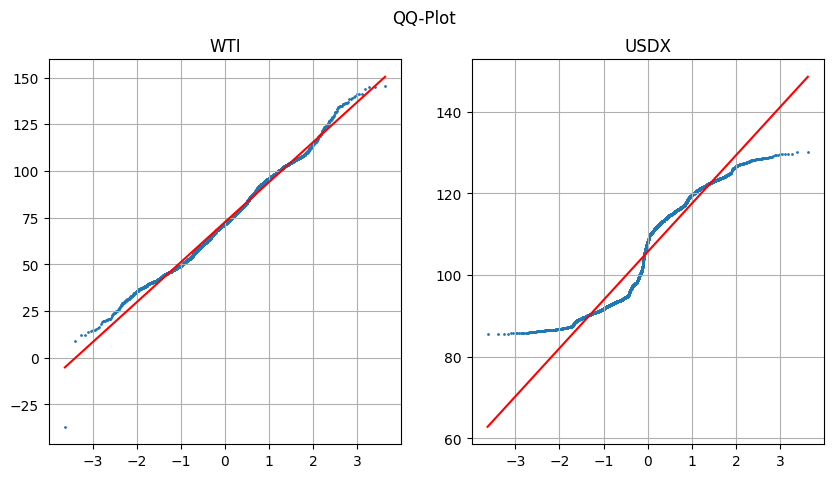

In [262]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
axs[0].scatter(osm_w, osr_w, s=1.0)
axs[1].scatter(osm_u, osr_u, s=1.0)
m_w, M_w = np.min(osm_w), np.max(osm_w)
m_u, M_u = np.min(osm_u), np.max(osm_u)
x_w = np.linspace(m_w, M_w, 100)
x_u = np.linspace(m_u, M_u, 100)
axs[0].plot(x_w, b_w + a_w * x_w, c="r")
axs[1].plot(x_u, b_u + a_u * x_u, c="r")
axs[0].grid()
axs[1].grid()
axs[0].set_title("WTI")
axs[1].set_title("USDX")
_ = fig.suptitle("QQ-Plot")

While WTI prices taken as independant samples are approximately Gaussian, this assumption is not verified for the dollar index.

> The p-value of the Pearson coefficient is not reliable since the pair of variables is not a bivariate Guassian.

In [263]:
wti_unit = (wti_np - np.mean(wti_np)) / np.std(wti_np)
usdx_unit = (usdx_np - np.mean(usdx_np)) / np.std(usdx_np)

res = wti_unit - rho * usdx_unit

r2 = 1 - np.var(res)  # wti with unit variance

print("R2 coefficient :", np.round(r2, decimals=2))

R2 coefficient : 0.24


The linear projection approximation is not satisfying, first because the time series are not stationary and the correlation coefficient is time-dependant.

For the next steps, one can think of other externalities (relevant time series) to project onto the wti curve.

### Looking at the increments

In [362]:
std = df.select(pl.exclude("date").std()).collect()
mean = df.select(pl.exclude("date").mean()).collect()

In [363]:
EPS = 0.1

df_increments = df.with_columns(
    pl.exclude("date").clip(lower_bound=EPS).log().diff()
).drop_nulls()

df_increments = df_increments.with_columns(
    pl.col("WTI spot").clip(
        upper_bound=pl.quantile("WTI spot", 0.99),
        lower_bound=pl.quantile("WTI spot", 0.01),
    ),
    pl.col("USDX").clip(
        upper_bound=pl.quantile("USDX", 0.99), lower_bound=pl.quantile("USDX", 0.01)
    ),
)

df_increments = df_increments.with_columns(
    (pl.col("WTI spot") - pl.mean("WTI spot")) / pl.std("WTI spot"),
    (pl.col("USDX") - pl.mean("USDX")) / pl.std("USDX"),
)


print(f"Number of days joined : {df_increments.select(pl.len()).collect().item()}")


df_p = df_increments.collect().to_pandas().set_index("date")

# df_no_nans = df_increments.drop_nulls()

# wti_np = df_no_nans.select(pl.col("WTI spot")).collect().to_numpy().T[0]
# usdx_np = df_no_nans.select(pl.col("USDX")).collect().to_numpy().T[0]

# wti_unit = (wti_np - np.mean(wti_np)) / np.std(wti_np)
# usdx_unit = (usdx_np - np.mean(usdx_np)) / np.std(usdx_np)
wti_unit = df_p["WTI spot"]
usdx_unit = df_p["USDX"]

# # wti_unit = np.clip(wti_unit, -2., 2.)

# wti_unit = (wti_unit - np.mean(wti_unit)) / np.std(wti_unit)

Number of days joined : 4789


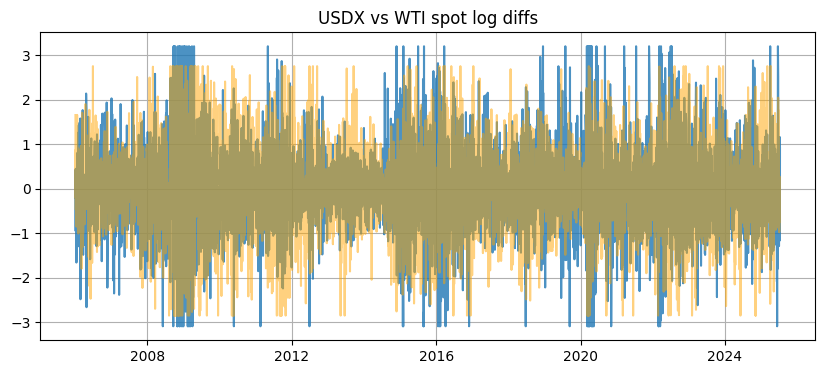

In [364]:
_, ax = plt.subplots(figsize=(10, 4))

datex = df_p.index
ax.plot(datex, wti_unit, alpha=0.8)
ax.plot(datex, usdx_unit, c="orange", alpha=0.5)
ax.grid()
_ = ax.set_title("USDX vs WTI spot log diffs")

In [365]:
print(
    f"Pearson correlation coefficient : {
df_increments.select(
    pl.corr(
        pl.col("WTI spot"), 
        pl.col("USDX"),
        method="pearson"
    )
).collect().item()
}"
)

Pearson correlation coefficient : -0.29585351751962435


### Lead-lag

In [366]:
for i in range(5)[::-1]:
    print("\nDays of lag : ", i)
    pr = pearsonr(wti_unit[i:], usdx_unit[:-i] if i > 0 else usdx_unit)
    print(f"Pearson coefficient : {np.round(pr.statistic, decimals=3)}")
    print(f"p-value : {np.round(pr.pvalue, decimals=5)}")


rho = pr.statistic


Days of lag :  4
Pearson coefficient : -0.026
p-value : 0.07217

Days of lag :  3
Pearson coefficient : 0.015
p-value : 0.28638

Days of lag :  2
Pearson coefficient : -0.018
p-value : 0.21287

Days of lag :  1
Pearson coefficient : -0.07
p-value : 0.0

Days of lag :  0
Pearson coefficient : -0.296
p-value : 0.0


Lagging USDX does not improve the correlation between the time series.
The price adjustment of WTI is likely to happen intraday.

### Linear projection of increments

In [367]:
(osm_w, osr_w), (a_w, b_w, _) = probplot(wti_unit, dist="norm", fit=True)
(osm_u, osr_u), (a_u, b_u, _) = probplot(usdx_unit, dist="norm", fit=True)

In [368]:
adf_wti, p_wti, lag_wti, *_ = adfuller(wti_unit)
adf_usdx, p_usdx, lag_usdx, *_ = adfuller(usdx_unit)
kpss_wti, pk_wti, lag_wti, *_ = kpss(wti_unit)
kpss_usdx, pk_usdx, lag_usdx, *_ = kpss(usdx_unit)

confidence_level = 0.01

print(f"""
WTI :
    Reject ADF : {p_wti < confidence_level}
    Reject KPSS : {pk_wti < confidence_level}

USDX :
    Reject ADF : {p_usdx < confidence_level}
    Reject KPSS : {pk_usdx < confidence_level}
""")


WTI :
    Reject ADF : True
    Reject KPSS : False

USDX :
    Reject ADF : True
    Reject KPSS : False



/tmp/ipykernel_26029/2429897587.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_wti, pk_wti, lag_wti, *_ = kpss(wti_unit)
/tmp/ipykernel_26029/2429897587.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_usdx, pk_usdx, lag_usdx, *_ = kpss(usdx_unit)


Both increments time series seem to not have a unit root.

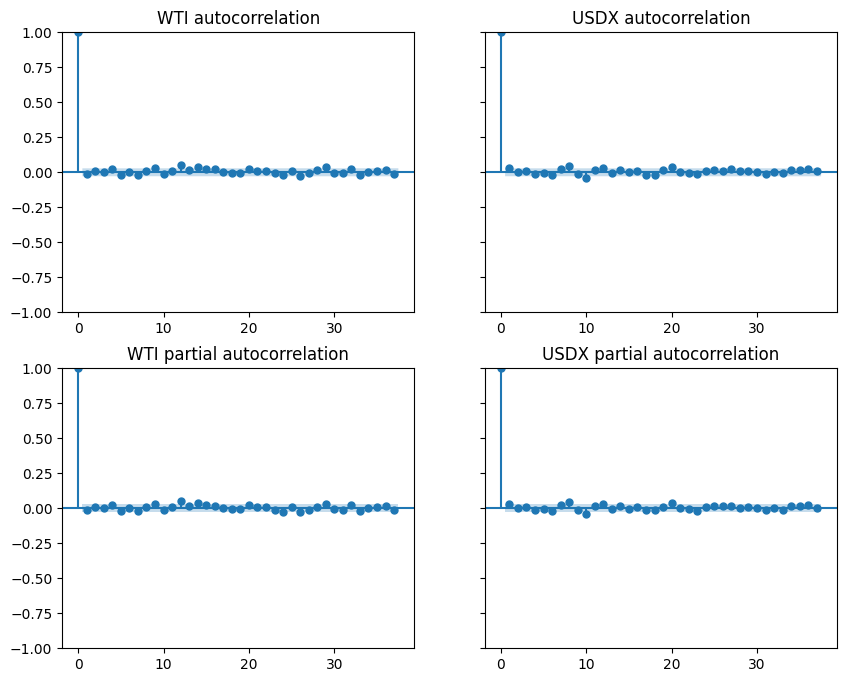

In [369]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 8), sharey=True)

_ = plot_acf(wti_unit, ax=axs[0][0], title="WTI autocorrelation", auto_ylims=True)
_ = plot_acf(usdx_unit, ax=axs[0][1], title="USDX autocorrelation", auto_ylims=True)
_ = plot_pacf(wti_unit, ax=axs[1][0], title="WTI partial autocorrelation")
_ = plot_pacf(usdx_unit, ax=axs[1][1], title="USDX partial autocorrelation")

In [370]:
model = VAR(df_p)

/home/leonc/code/fixed-income-analytics/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/leonc/code/fixed-income-analytics/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [371]:
var_res = model.fit()
var_res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 24, Jul, 2025
Time:                     21:48:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                 -0.0876212
Nobs:                     4788.00    HQIC:                -0.0928842
Log likelihood:          -13352.6    FPE:                   0.908706
AIC:                   -0.0957338    Det(Omega_mle):        0.907568
--------------------------------------------------------------------
Results for equation WTI spot
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.000216         0.014412           -0.015           0.988
L1.WTI spot        -0.032490         0.015088           -2.153           0.031
L1.USDX            -0.079916         0.015092           -5.295   

In [372]:
var_res.k_ar

1

In [374]:
1.0 - var_res.resid.var() / df_p.var()

WTI spot    0.005867
USDX        0.001695
dtype: float64

In [426]:
fitted_wti = (
    np.exp(var_res.fittedvalues["WTI spot"].cumsum()) * df_p["WTI spot"].std()
    + df.select(pl.col("WTI spot").first()).collect().item()
)  # mean.select(pl.col("WTI spot")).item()

fitted_wti = (
    fitted_wti + rho * df_p["USDX"] / df_p["USDX"].std() * df_p["WTI spot"].std()
)

In [427]:
df_pd = df.collect().to_pandas().set_index("date")

usd_proj = (
    rho
    * (df_pd["USDX"] - df_pd["USDX"].mean())
    / df_pd["USDX"].std()
    * df_pd["WTI spot"].std()
)
usd_proj

date
2025-07-14   -7.708840
2025-07-11   -7.558965
2025-07-10   -7.516351
2025-07-09   -7.468668
2025-07-08   -7.519402
                ...   
2006-01-09    2.865049
2006-01-06    2.945365
2006-01-05    2.803092
2006-01-04    2.839501
2006-01-03    2.566954
Name: USDX, Length: 4902, dtype: float64

<Axes: xlabel='date'>

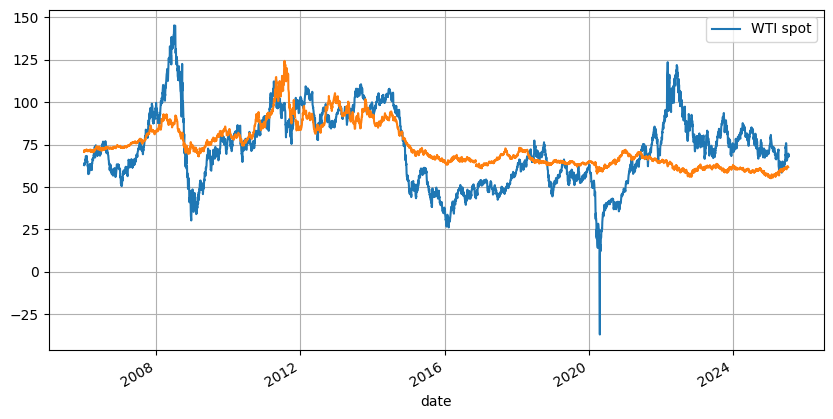

In [431]:
wti = (
    df.select([pl.col("WTI spot"), pl.col("date")])
    .collect()
    .to_pandas()
    .set_index("date")
)
_, ax = plt.subplots(figsize=(10, 5))
wti.plot(ax=ax)
(usd_proj + fitted_wti).plot(ax=ax, grid=True)
# .plot(ax=ax, c="green")

In [409]:
1 - (wti["WTI spot"] - fitted_wti).var() / wti["WTI spot"].var()

np.float64(0.2720391590344492)

In [429]:
1 - (wti["WTI spot"] - fitted_wti - usd_proj).var() / wti["WTI spot"].var()

np.float64(0.3339940286746642)

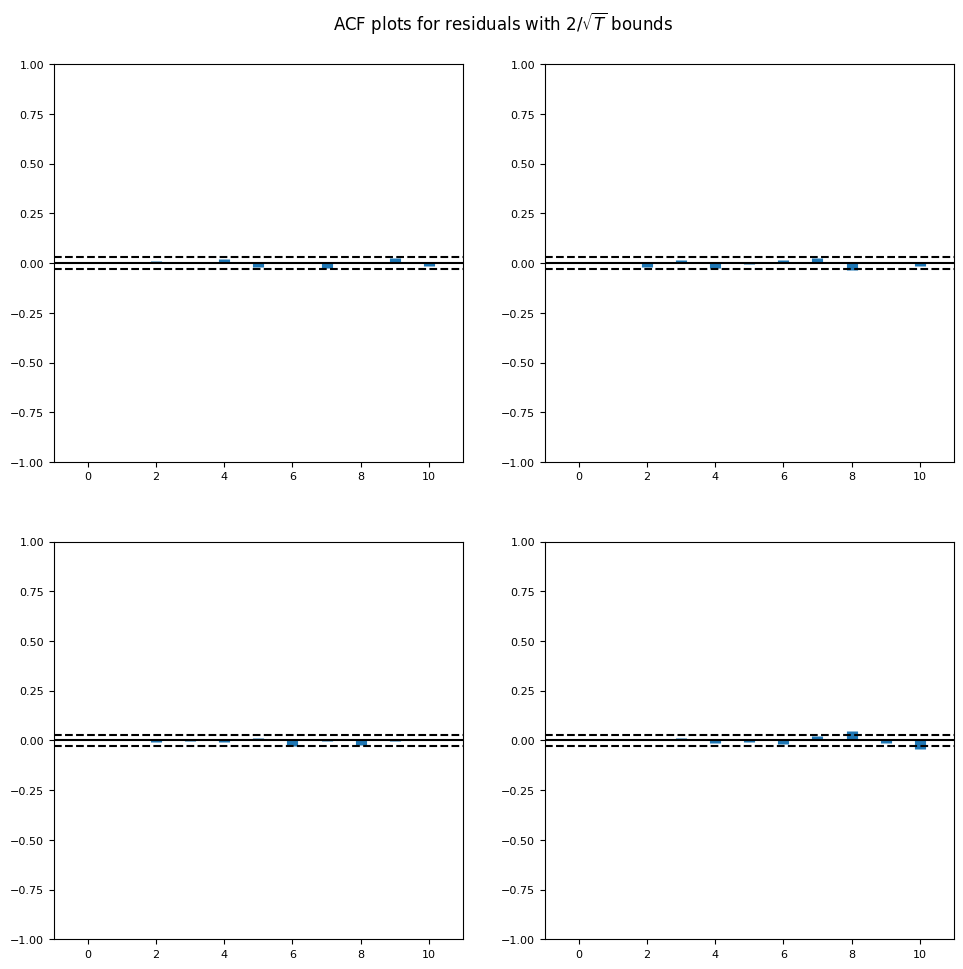

In [338]:
_ = var_res.plot_acorr()

In [340]:
irf = var_res.irf(10)

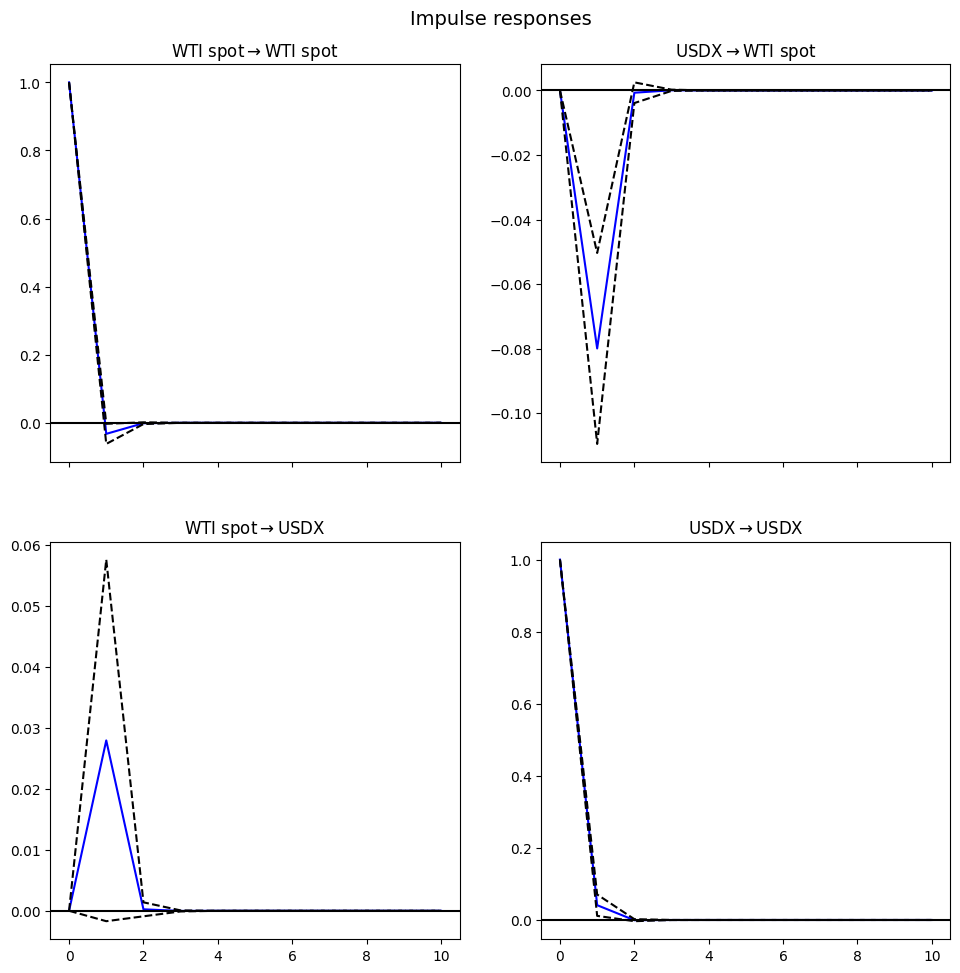

In [342]:
_ = irf.plot()

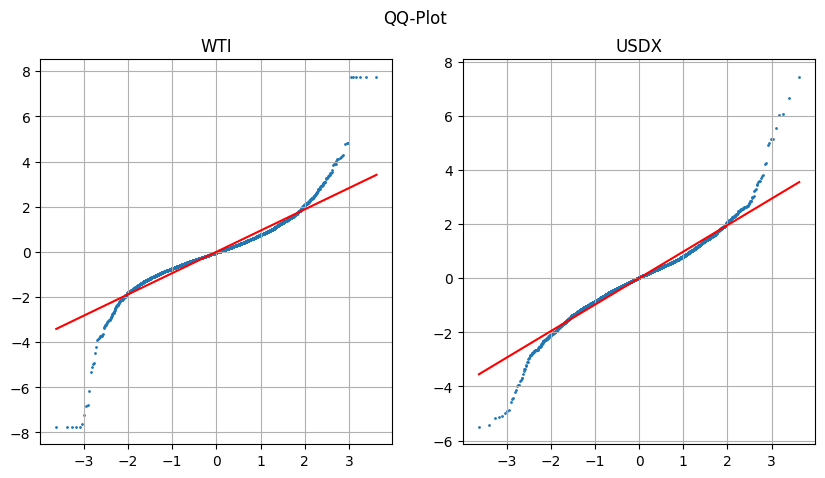

In [276]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
axs[0].scatter(osm_w, osr_w, s=1.0)
axs[1].scatter(osm_u, osr_u, s=1.0)
m_w, M_w = np.min(osm_w), np.max(osm_w)
m_u, M_u = np.min(osm_u), np.max(osm_u)
x_w = np.linspace(m_w, M_w, 100)
x_u = np.linspace(m_u, M_u, 100)
axs[0].plot(x_w, b_w + a_w * x_w, c="r")
axs[1].plot(x_u, b_u + a_u * x_u, c="r")
axs[0].grid()
axs[1].grid()
axs[0].set_title("WTI")
axs[1].set_title("USDX")
_ = fig.suptitle("QQ-Plot")

Both time series present heavy-tail increments.

In [277]:
res = wti_unit - rho * usdx_unit
r2 = 1 - np.var(res)  # wti with unit variance
print("R2 coefficient :", np.round(r2, decimals=2))

R2 coefficient : 0.07


***
## Sources

- https://open.spotify.com/episode/0LroaxByEYdHk5Bbzg7CMM

Data :
- https://finance.yahoo.com/quote/DX-Y.NYB/history/
- https://www.eia.gov/dnav/pet/hist/RWTCD.htm
